# Social Network Analysis - Exercise Sheet 4a)


### Roles in graphs.

In this exercise, we will determine roles in graphs based on (equivalence) relations. More specifically, you will implement methods which decide whether some relation is fullfilled. Based on these and some generic equivalence relations that a user can specify, you will compute partitions of graphs as well as maximal roles.

#### Guidelines
* Submit your code zipped via [moodle](https://moodle.uni-kassel.de/course/view.php?id=11038) until 12.01.2023 23:55 MEZ
* Use the [NetworkX](https://networkx.github.io/documentation/stable/) library for your graphs.

##### Exercise 1:
1. Implement a function which decides whether two nodes of a graph are structurally equivalent.
2. Implement a function which for some relation decides whether it is an equivalence relation.
3. Implement a function which takes as its parameters some input equivalence decision function and a graph. The function then computes a partition of the graph based on the equivalence relation.
4. Implement a function which, for some input equivalence decision function, computes maximal roles.
5. Provide an example network and compute all roles. What insights do you get?

# Structural Equivalence (Def. 9.1)
- undirected graph G, vertices v,w
- v and w are structurally equivalent if
    - for all vertices u: u is adjacent to v iff u is adjacent to w (same neighbourhood)

# TODO: directed graph

In [235]:
def check_structural_equivalence(graph, v, w):
    '''
    :param graph: a networkx graph
    :param v: a node in graph
    :param w: a node in graph
    
    :return: True if v and w are structurally equivalent (Def. 9.10), False otherwise
    '''
    return set(graph.neighbors(v)) == set(graph.neighbors(w))

# Equivalence Relation (Def. 9.4)
- relation R on set M
- R is equivalence relation if
    - R is reflexive
    - R is symmetric
    - R is transitive

In [236]:
def check_equivalence_relation(relation):
    '''
    :param relation: a list of tuples (v, w) where v and w are nodes in a graph that are in relation to each other
    :return: True if relation is an equivalence relation, False otherwise
    '''
    for v, w in relation:
        # reflexivity
        if v != w and (((v, v) not in relation) or ((w, w) not in relation)):
            print('not reflexive')
            return False
        
        # symmetry
        if (w, v) not in relation:
            print('not symmetric')
            return False
    
        # transitivity: (v, w) and (w, u[0]) implies (v, u[1])
        for u in relation:
            if (u[0] == w) and (not (v, u[1]) in relation):
                print('not transitive')
                return False
    return True

In [237]:
import itertools


def compute_equivalence_partition(equiv_relation, graph):
    '''
    :param equiv_relation: a function that takes a node in graph and returns its value
    :param graph: a networkx graph
    :return: a list of equivalence classes (each class is a set of nodes)
    '''
    combos = list(itertools.product(list(graph.nodes()), repeat=2))
    relation = [(x,y) for x,y in combos if equiv_relation(x,y)]
    #assert check_equivalence_relation(relation), 'relation is not an equivalence relation.'

    partition = {}
    for node1, node2 in itertools.combinations(list(graph.nodes()), 2):
        output = equiv_relation(node1, node2)
        partition.setdefault(node1, set([node1]))
        if output:
            partition[node1] = partition[node1].union(set([node2]))

    for class1, class2 in itertools.combinations(partition.keys(), 2):
        if (class1 not in partition.keys()) or (class2 not in partition.keys()):
            continue
        if partition[class2].issubset(partition[class1]):
            del(partition[class2])
            
    return list(partition.values())

    

In [238]:
# examples from https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.minors.equivalence_classes.html
from networkx import equivalence_classes
import networkx as nx


X = set(range(10))
def mod3(x, y): return (x - y) % 3 == 0

nx_sol = equivalence_classes(X, mod3)
print(nx_sol)
graph = nx.Graph()
graph.add_nodes_from(X)
print(compute_equivalence_partition(mod3, graph))

{frozenset({1, 4, 7}), frozenset({8, 2, 5}), frozenset({0, 9, 3, 6})}
[{0, 9, 3, 6}, {1, 4, 7}, {8, 2, 5}]


# Role (Def. 9.7)
- graph G, structural equivalence relation R
- equivalence class of vertex v is its role 

VL provides algorithm for computing maximal structural equivalence on undirected graphs

In [239]:
def maximal_structural_equivalence(graph):
    '''
    :param graph: a networkx graph
    :return: a list of maximal structural equivalence classes (each class is a set of nodes)
    '''
    new_role = 1
    roles = {}
    for node in graph.nodes():
        roles.setdefault(node, 1)
    temp_role = {}
    temp_role[new_role] = 0
    for node in graph.nodes():
        for neighbor in graph.neighbors(node):
            if temp_role[roles[neighbor]] == 0:
                new_role += 1
                temp_role[roles[neighbor]] = new_role
                temp_role[new_role] = roles[neighbor]
            roles[neighbor] = temp_role[roles[neighbor]]
        for neighbor in graph.neighbors(node):
            temp_role[temp_role[roles[neighbor]]] = 0
            temp_role[roles[neighbor]] = 0
    return roles

In [240]:
def get_colour_map(classes) -> dict:
    '''
    :param classes: list of set of nodes, each representing a structural equivalence class
   
    :return: dictionary of colours for nodes, where blue is core and red is periphery
    '''
    colour_map = {}
    for colour, equiv_class in enumerate(classes):
        colour_map.update({node: colour for node in equiv_class})
    return colour_map

{0: 12, 1: 13, 2: 14, 3: 12, 4: 13, 5: 14, 6: 12, 7: 13, 8: 14, 9: 12, 'class 0': 11, 'class 1': 9, 'class 2': 10}


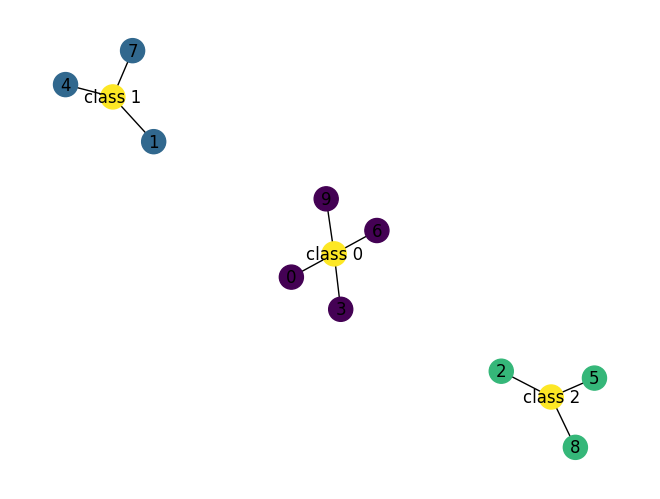

In [241]:
# test

graph = nx.Graph()
graph.add_nodes_from(list(range(10)))
edges = []
equivalence_classes = compute_equivalence_partition(mod3, graph)
for i, equiv_class in enumerate(equivalence_classes):
    for v in equiv_class:
        edges.append((v, f'class {i}'))
graph.add_edges_from(edges)
extended_classes = equivalence_classes.copy()
extended_classes.append(set([i for i in range(len(graph.nodes()), len(graph.nodes())+len(equivalence_classes))]))
colour_map = get_colour_map(extended_classes)
colour_map = dict(sorted(colour_map.items()))   # colourmap order: (C nodes, P nodes) != order of nodes in G 
nx.draw(graph, with_labels = True, node_color= list(colour_map.values()))

max_struc_equiv = maximal_structural_equivalence(graph)
print(max_struc_equiv) # ignore 'class i' nodes
for equiv_class in equivalence_classes:
    assert len(set([max_struc_equiv[v] for v in equiv_class])) == 1, 'elements in the same equivalence class should have the same role'

# Insights from example network